# Implementing and testing bi-cross validation for determining the number of orthogonal basis components to be retained by SVD

based on
Bi-Cross Validation of the SVD and the Non-Negative Matrix Factorization
The Annals of Applied Statistics, Vol.3 No. 2, 564-594 DOI:10.1214/08-AOAS227 Art B. Owen and Partick O. Perry

## loading libraries

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import svm
from sklearn.decomposition import TruncatedSVD,PCA
from matplotlib import pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_validate
#from sklearn.model_selection import cross_validate
from sklearn import linear_model
from sklearn.model_selection import ShuffleSplit
import inspect
from sklearn.metrics import fbeta_score, make_scorer,mean_squared_error
from sklearn import linear_model
import random

## loading or generating data set

In [186]:
#generating fake data set.
def make_y_stack(noise_amplitude,low_freq_noise):

    x = np.arange(-200,200,1)
    y_stack = []
    for i in np.arange(100):
        #creating shifted gaussians of different width
        y = np.exp(-(x-75*(np.random.rand()-0.5))**2/(40**2*(1+np.random.rand())))
        y += 0.01*np.sin(x/10.0)
        #additing some low frequency noise
        y = y + noise_amplitude*np.convolve(np.ones(2)/20,np.random.rand(x.shape[0])-0.5,mode='same')
        y = y + low_freq_noise*np.cumsum(noise_amplitude*np.convolve(np.ones(2)/20,np.random.rand(x.shape[0])-0.5,mode='same'))
        y_stack.append(y)
    y_stack = np.vstack(y_stack)

    return x,y_stack
x, y_stack = make_y_stack(1,1)

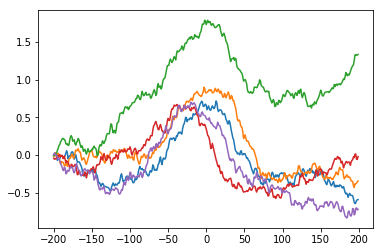

In [187]:
plt.plot(x,y_stack[0:5].transpose())
plt.show()

## numpy svd

In [188]:
u,s,v = np.linalg.svd(y_stack)

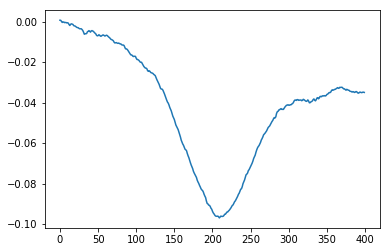

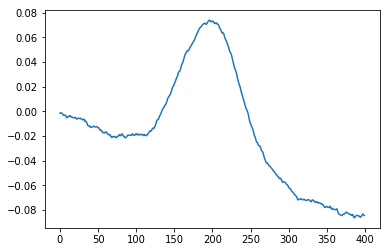

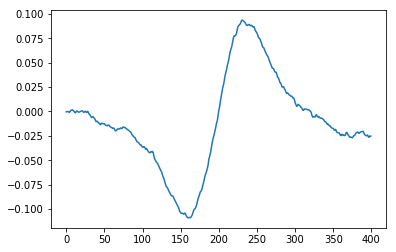

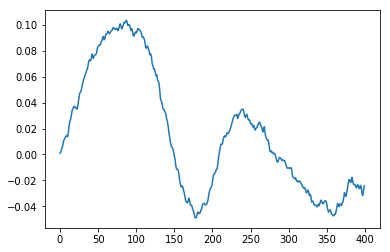

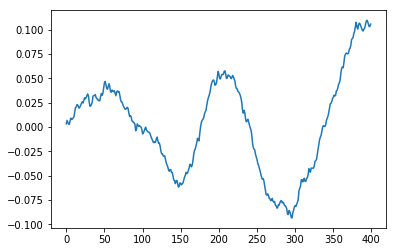

In [189]:
for i in np.arange(5):
    plt.plot(v[i])
    plt.show()

## The goal is to be able to use cross_val_score

In [190]:
#step 1, do SVD of D part of of y_stack where y_stack = array([[A,B][C,D]])
def break_X_into_ABCD(X,d_n_columns,d_n_rows,):
    
    #returns A,B,C,D
    return X[d_n_columns:,d_n_rows:],X[:d_n_columns,d_n_rows:],X[d_n_columns:,:d_n_rows],X[:d_n_columns,:d_n_rows]
    
    

In [191]:
y_stack.shape

(100, 400)

In [192]:
A,B,C,D = break_X_into_ABCD(y_stack,45,195)

In [193]:
D.shape

(45, 195)

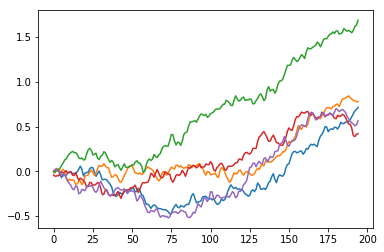

In [194]:
plt.plot(D[0:5].transpose())
plt.show()

In [195]:
#comparing sklearn SVD
my_svd = TruncatedSVD(n_components=12, n_iter=7, random_state=42)
my_svd.fit(D)  

TruncatedSVD(algorithm='randomized', n_components=12, n_iter=7,
       random_state=42, tol=0.0)

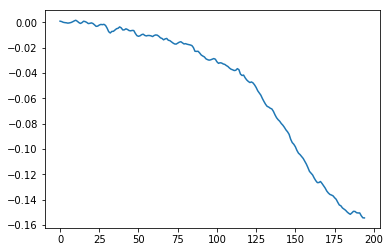

In [196]:
Ud,Sd,Vd = np.linalg.svd(D)
plt.plot(Vd[0])
plt.show()

In [197]:
k = 11
Sd[k:] = 0
#reconstructed_D = np.dot(np.dot(Ud,np.diag(Sd)),Vd[:len(Sd)])       #numpy SVD reconstructed
reconstructed_D = np.dot(my_svd.fit_transform(D),my_svd.components_) #sklearn reconstructed


In [198]:
#sklearn_reconstructed_d = np.dot(my_svd.fit_transform(D),my_svd.components_).transpose()

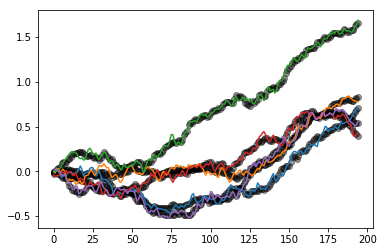

In [199]:
plt.plot(reconstructed_D[0:5].transpose(),'ko',alpha=0.4)
plt.plot(D[0:5].transpose())
#plt.plot(sklearn_reconstructed_d[:,0:5],'k-')
plt.show()

In [200]:
D_k_penrose = np.linalg.pinv(reconstructed_D)          #one of these isn't working properly
#D_k_penrose = np.dot(np.linalg.inv(np.dot(reconstructed_D.transpose(),reconstructed_D)),reconstructed_D.transpose())
#D_k_penrose = np.dot(np.linalg.inv(np.dot(reconstructed_D,reconstructed_D.transpose(),)),reconstructed_D).transpose()

In [201]:
#now estimating A from B,D_k_penrose, and C
#A_bi_cross_estimate = np.dot(B,np.dot(D_k_penrose,C))
#A_bi_cross_estimate = np.dot(np.dot(C,D_k_penrose),B)
A_bi_cross_estimate = np.dot(np.dot(B.transpose(),D_k_penrose.transpose()),C.transpose())

In [202]:
A.shape

(55, 205)

In [203]:
A_bi_cross_estimate.shape

(205, 55)

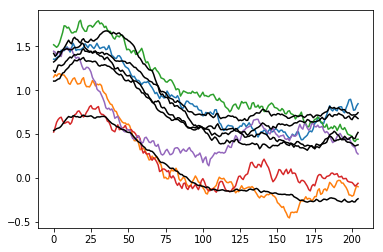

In [204]:
plt.plot(A[:5].transpose())
plt.plot(A_bi_cross_estimate.transpose()[:5].transpose(),'k-')
plt.show()

In [205]:
MSE = np.sum((A-A_bi_cross_estimate.transpose())**2)

In [206]:
MSE

2176.700532098773

## Now putting into one big function

In [207]:
def break_X_into_ABCD(X,d_n_columns,d_n_rows,):
    
    #returns A,B,C,D
    return X[d_n_columns:,d_n_rows:],X[:d_n_columns,d_n_rows:],X[d_n_columns:,:d_n_rows],X[:d_n_columns,:d_n_rows]

def predict(y_stack,**kwargs):
    options = {
        'k' : 2,
        'd_n_rows'     : int(y_stack.shape[0]/2),
        'd_n_cols'     : int(y_stack.shape[1]/2),
        'SVD_package'  : 'numpy'}

    options.update(kwargs)

    A,B,C,D = break_X_into_ABCD(y_stack,options['d_n_rows'],options['d_n_cols'])
    
    if(options['SVD_package'] == 'sklearn'):

        my_svd = TruncatedSVD(n_components=options['k'], n_iter=7, random_state=42)
        my_svd.fit(D) 
        reconstructed_D = np.dot(my_svd.fit_transform(D),my_svd.components_)
        
    else:
        Ud,Sd,Vd = np.linalg.svd(D)
        Sd[options['k']:] = 0
        reconstructed_D = np.dot(np.dot(Ud,np.diag(Sd)),Vd[:len(Sd)]) 
    
    D_k_penrose = np.linalg.pinv(reconstructed_D) 
    A_bi_cross_estimate = np.dot(np.dot(B.transpose(),D_k_penrose.transpose()),C.transpose())
    
    return A_bi_cross_estimate.transpose()
    
def score(*args,**kwargs):
    
    options = {
    'k' : 2,
    'd_n_rows' : int(y_stack.shape[0]/2),
    'd_n_cols' : int(y_stack.shape[1]/2),
    'SVD_package'  : 'numpy'}
    
    options.update(kwargs)

    A_bi_cross_estimate = predict(*args,**kwargs)
    A,B,C,D = break_X_into_ABCD(args[0],options['d_n_rows'],options['d_n_cols'])
    return np.sum((A-A_bi_cross_estimate)**2)

In [226]:
x, y_stack = make_y_stack(1.000,.2)
A,B,C,D = break_X_into_ABCD(y_stack,50,200)

In [227]:
A_bi_cross_estimate = predict(y_stack,k=21)
A_bi_cross_estimate.shape

(50, 200)

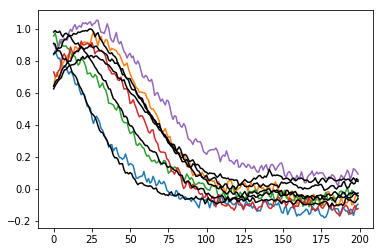

In [230]:
plt.plot(A[:5].transpose())
plt.plot(A_bi_cross_estimate[:5].transpose(),'k-')
plt.show()

In [214]:
score(y_stack,k=16,d_n_rows=70,d_n_cols=300)

42.39663932150776

## iterating over values of k to find best one

In [215]:
x, y_stack = make_y_stack(.10,.015)         #for debugging: putting 0 yields expected behavior, but only with no shuffling

n_interations=20
row_range = range(y_stack.shape[0])
col_range = range(y_stack.shape[1])
MSE_list = []
max_k = 40
#my_matrix = 0+ y_stack

for j in np.arange(n_interations):

    row_shuffling = np.array(random.sample(row_range,len(row_range)))     
    col_shuffling = np.array(random.sample(col_range,len(col_range)))
    
    my_matrix =  y_stack[row_shuffling]           #shuffling is messing things up, and it's not clear why
    my_matrix =  my_matrix[:,col_shuffling]
    #my_matrix = 0+ y_stack

    temp_MSE_list=[]
    
    for k in np.arange(1,max_k):
    

        
        temp_MSE_list.append(score(my_matrix,k=k,d_n_rows=50,d_n_cols=200,SVD_package='numpy'))
        
    MSE_list.append(temp_MSE_list)

In [216]:
median_MSE_list = np.median(np.array(MSE_list),axis=0)
mean_MSE_list = np.mean(np.array(MSE_list),axis=0)
std_MSE_list = np.std(np.array(MSE_list),axis=0)/n_interations**0.5

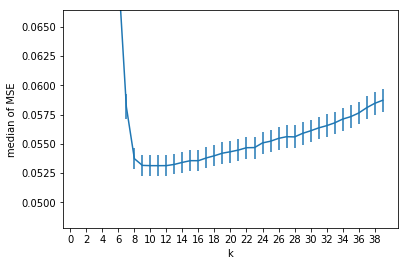

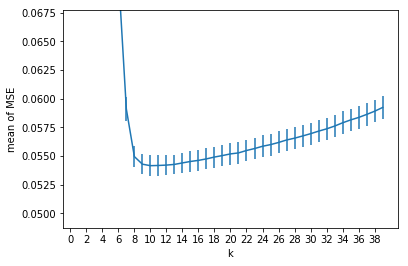

In [219]:
plt.errorbar(np.arange(1,max_k),median_MSE_list,yerr=(std_MSE_list))
plt.ylim(0.9*np.min(median_MSE_list),1.25*np.min(median_MSE_list))
plt.ylabel("median of MSE")
plt.xticks(np.arange(0,max_k,2))
plt.xlabel("k")
plt.show()
plt.errorbar(np.arange(1,max_k),mean_MSE_list,yerr=(std_MSE_list))
plt.ylim(0.9*np.min(mean_MSE_list),1.25*np.min(mean_MSE_list))
plt.xticks(np.arange(0,max_k,2))
plt.xlabel("k")
plt.ylabel("mean of MSE")
plt.show()

## now implementing this above is sklearn compatible object  (in progress)

### First trying inheritance of truncated SVD class

In [384]:
## Let's make those methods
#TruncatedSVD(n_components=5, n_iter=17, random_state=42)
class cross_validatable_svd(TruncatedSVD):
    
    def __init__(self,**kwargs):
        
        options = {'debug':False}
        options.update(kwargs)
        self._debug = options['debug']
        
        super().__init__(**kwargs)
        
    
    #this solves the problem where def self.n_components does not get instantiated by cross_val_score
    #def fit(self,*args,n_components=3,**kwargs): 
    #    self.n_components = int(n_components)
    #    return super().fit(*args,**kwargs)
    
    def fit(self,*args,**kwargs):
        self.original_matrix = args[0]
        return super().fit(*args,**kwargs)    
    
    def break_X_into_ABCD(self,d_n_columns,d_n_rows,shuffle):
        
        if(shuffle):
            row_range = range(self.original_matrix.shape[0])
            col_range = range(self.original_matrix.shape[1])
            row_shuffling = np.array(random.sample(row_range,len(row_range)))     
            col_shuffling = np.array(random.sample(col_range,len(col_range)))
            
            X =  self.original_matrix[row_shuffling]           #shuffling is messing things up, and it's not clear why
            X =  X [:,col_shuffling]
    
        #returns A,B,C,D
        #return X[d_n_columns:,d_n_rows:],X[:d_n_columns,d_n_rows:],X[d_n_columns:,:d_n_rows],X[:d_n_columns,:d_n_rows]
        else:
            X = self.original_matrix
            
        self.A,self.B,self.C,self.D = X[d_n_columns:,d_n_rows:],X[:d_n_columns,d_n_rows:],X[d_n_columns:,:d_n_rows],X[:d_n_columns,:d_n_rows]

        return 0
        
    def predict(self,*args,**kwargs):
        options = {
            'd_n_rows' : int(y_stack.shape[0]/2),
            'd_n_cols' : int(y_stack.shape[1]/2),
            'shuffle'  : False}

        options.update(kwargs)

        self.break_X_into_ABCD(options['d_n_rows'],options['d_n_cols'],options['shuffle'])
        A,B,C,D = self.A,self.B,self.C,self.D

        my_svd = TruncatedSVD(n_components=self.n_components, n_iter=7, random_state=42)
        my_svd.fit(D) 
        self.reconstructed_D = np.dot(my_svd.fit_transform(D),my_svd.components_)
        D_k_penrose = np.linalg.pinv(self.reconstructed_D) 
        A_bi_cross_estimate = np.dot(np.dot(B.transpose(),D_k_penrose.transpose()),C.transpose())

        self.A_bi_cross_estimate = A_bi_cross_estimate.transpose()
        
        return self.A_bi_cross_estimate

    def score(self,*args,**kwargs):

        options = {
        'd_n_rows' : int(y_stack.shape[0]/2),
        'd_n_cols' : int(y_stack.shape[1]/2), 
        'shuffle'  : False}

        options.update(kwargs)

        #self.break_X_into_ABCD(options['d_n_rows'],options['d_n_cols'],options['shuffle'])
        if(self._debug):
            print("self:"+str(self))
            print("args:"+str(args))
            print("kwargs:"+str(kwargs))
        self.A_bi_cross_estimate = self.predict(*args,**kwargs)
        
        
        A = self.A
        
        self.bi_cross_MSE = np.sum((A-self.A_bi_cross_estimate)**2)
        
        return self.bi_cross_MSE        

### testing the score method

In [385]:
x, y_stack = make_y_stack(3.0) #make the data

In [386]:
#setup sklearn uobject
my_svd = TruncatedSVD(n_components=4, n_iter=17, random_state=42)
my_svd.fit(y_stack)

TruncatedSVD(algorithm='randomized', n_components=4, n_iter=17,
       random_state=42, tol=0.0)

In [387]:

score_list = []
for n_components in np.arange(20):
    my_svd = cross_validatable_svd(n_components=n_components, n_iter=17, random_state=42)
    my_svd.fit(y_stack)
    score_list.append(my_svd.score(shuffle=True))
    
    

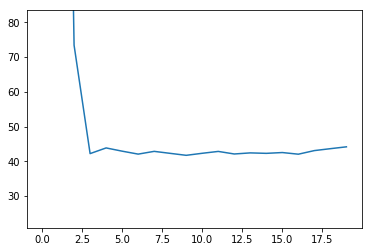

In [388]:
#results are consistent
plt.plot(score_list)
plt.ylim(0.5 *np.min(score_list),2 *np.min(score_list))
plt.show()

## Testing with cross_val_score

In [389]:
my_svd._debug = False

In [390]:
my_fit_params = None
scores = cross_val_score(my_svd, y_stack,cv=6)
my_svd.fit(y_stack)
my_svd.score()

190.8137979383571

In [397]:
scores

array([192.5437118 , 193.64634821, 189.70961887, 214.68982439,
       242.31725393, 242.8187492 ])

In [395]:
my_svd = cross_validatable_svd(n_components=n_components, n_iter=17, random_state=42)
#scores = cross_val_score(my_svd, y_stack,cv=2)
my_cross_validator = cross_validate(my_svd, y_stack,cv=3)

In [396]:
my_cross_validator

/home/mouth_breather/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


{'fit_time': array([0.00845838, 0.00279117, 0.00256443]),
 'score_time': array([0.00702095, 0.00672507, 0.00724244]),
 'test_score': array([ 81.44643931,  89.03021063, 130.59661845]),
 'train_score': array([ 81.44643931,  89.03021063, 130.59661845])}

In [366]:
score_list = []
for n_components in np.arange(20):
    my_svd = cross_validatable_svd(n_components=n_components, n_iter=17, random_state=42)
    scores = cross_val_score(my_svd, y_stack,cv=4)
    score_list.append(np.mean(scores))

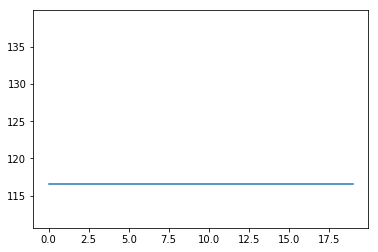

In [367]:
plt.plot(score_list)
plt.ylim(0.95 *np.min(score_list),1.2*np.min(score_list))
plt.show()

### Now trying using base estimator class

### to do list

find thin wrapper for matplotlib.  Graph settings are getting too tedious